In [54]:
from sklearn.decomposition import DictionaryLearning, MiniBatchDictionaryLearning
from sklearn.feature_extraction.image import extract_patches_2d, reconstruct_from_patches_2d
from sklearn.datasets import load_digits, make_sparse_coded_signal
from skimage.color import rgb2gray
from skimage import data
import matplotlib.pyplot as plt 
import numpy as np
from utilities import *

# Dictionary learning

* Some images may be naturally sparse under different linear transforms
* We may not know a good transform, can we build one from a set of training images?

We need to solve

$$\min_{z, D} \sum_{i=1}^m \frac{1}{2}\|Dz_i - u_i\|_2^2 + \alpha \|z_i\|_1,$$

under suitable constraints on $D$.

In [3]:
n_train = 100
n_test = 50

digits = load_digits()
U_train = digits.data[:n_train]
U_test = digits.data[n_train:n_train+n_test]

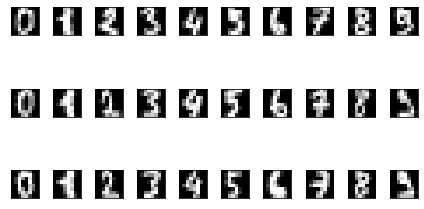

In [5]:
show_data(U_train[:30],3,10)

In [36]:
# initialise dictionary learner
dict_learner = MiniBatchDictionaryLearning(n_components=20, alpha = 1e1, transform_algorithm='lasso_lars', random_state=42)

# learn dictionary and fit
Z_train = dict_learner.fit_transform(U_train)

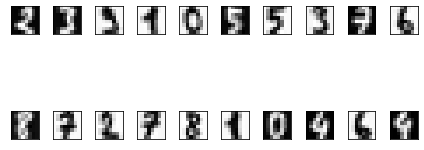

In [37]:
# plot dictionary elements
show_data(dict_learner.components_,2,10)

In [38]:
# compute testing error
Z_test = dict_learner.transform(U_test)

# compute sparsity level
print('NNZ:', np.mean(Z_test == 0)/64/n_test)

# compute training error (MSE)
U_hat = Z_test @ dict_learner.components_
print('MSE:', np.mean(np.sum((U_hat - U_test) ** 2, axis=1) / np.sum(U_test ** 2, axis=1)))

NNZ: 0.000164375
MSE: 0.06390631102239473


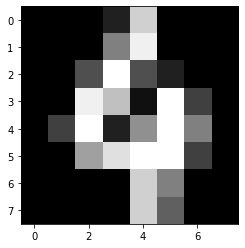

In [47]:
plt.imshow(U_test[0].reshape(8,8),cmap='gray')

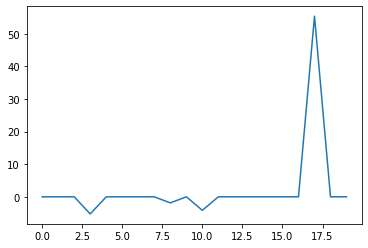

In [48]:
plt.plot(Z_test[0])

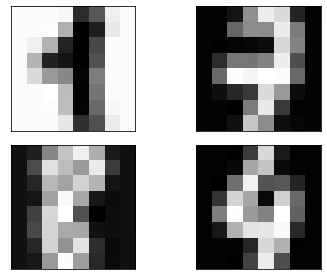

In [52]:
show_data(dict_learner.components_[np.abs(Z_test[0])>0],2,2)

# Practical aspects

* In practice, we would learn a dictionary of image patches

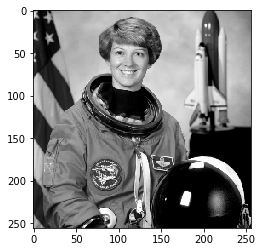

In [106]:
u = rgb2gray(data.astronaut())
u = u[::2,::2]
plt.imshow(u,cmap='gray')

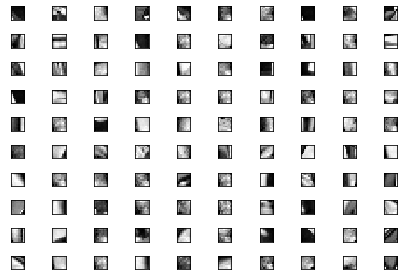

In [107]:
# extract patches
patches = extract_patches_2d(u,(8,8),max_patches=100)
patches = patches.reshape(patches.shape[0], -1)
patches -= np.mean(patches, axis=0)
patches /= np.std(patches, axis=0)
show_data(patches,10,10)

In [108]:
# initialise dictionary learner
dict_learner = MiniBatchDictionaryLearning(n_components=20, transform_alpha = 1, random_state=42, transform_algorithm = 'lasso_lars')

# learn dictionary
dict_learner.fit(patches)

MiniBatchDictionaryLearning(n_components=20, random_state=42,
                            transform_algorithm='lasso_lars',
                            transform_alpha=1)

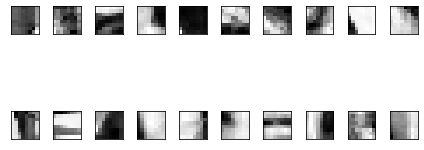

In [109]:
# show dictionary
show_data(dict_learner.components_,2,10)

/opt/anaconda3/envs/astra/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  """Entry point for launching an IPython kernel.


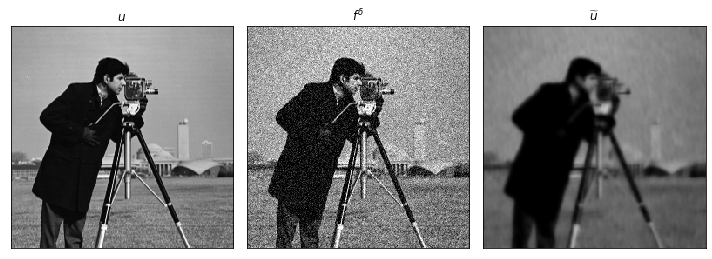

In [114]:
u = rgb2gray(data.camera())
u = u[::2,::2] / 255

delta = 1e-1
f_delta = u + delta * np.random.randn(u.shape[0],u.shape[1])

p_delta = extract_patches_2d(f_delta ,(8,8))
p_delta = p_delta.reshape(p_delta.shape[0], -1)

p = dict_learner.transform(p_delta) @ dict_learner.components_
#p = p_delta
image = reconstruct_from_patches_2d(p.reshape((p.shape[0],8,8)), (256,256))

plot_images([u,f_delta,image], [r'$u$',r'$f^\delta$',r'$\widetilde{u}$'])

# Assignment: bias-variance

* compare the dictionary method to TV denoising